# Narrow band analysis with 50e-4 white noise std

Here we study the results from the narrow-band modelling. 

## Running the code

The modelling is done using `fit_color.py` and `fit_color_dw.py` scripts. 

```bash
./fit_color.py --n-walkers 300 --n-threads 2 --do-mc --run-name nomask --de-n-iterations 600 --mc-n-iterations 15000 --mc-n-runs 15 --mc-thin 50 --lc-name "final/nb_nomask"

./fit_color.py --n-walkers 300 --n-threads 2 --do-mc --run-name masked --de-n-iterations 600 --mc-n-iterations 15000 --mc-n-runs 15 --mc-thin 50 --lc-name "final/nb_masked"

./fit_color_dw.py --n-walkers 400 --n-threads 2 --do-mc --run-name nomask --de-n-iterations 600 --mc-n-iterations 15000 --mc-n-runs 15 --mc-thin 50 --lc-name "nomask"

./fit_color_dw.py --n-walkers 400 --n-threads 2 --do-mc --run-name masked --de-n-iterations 600 --mc-n-iterations 15000 --mc-n-runs 15 --mc-thin 50 --lc-name "masked"

./fit_color_gp.py --n-walkers 400 --n-threads 2 --do-mc --run-name nomask --de-n-iterations 600 --mc-n-iterations 15000 --mc-n-runs 15 --mc-thin 50 --lc-name "nomask"

./fit_color_gp.py --n-walkers 400 --n-threads 2 --do-mc --run-name masked --de-n-iterations 600 --mc-n-iterations 15000 --mc-n-runs 15 --mc-thin 50 --lc-name "masked"
```

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sb

from mpl_toolkits.axes_grid1 import make_axes_locatable
from src.lpf_nd import LPFunction as LPFM
from src.core import *

In [3]:
ddir   = 'results'
dfiles = ['WASP_80b_color_nomask_wn_mc_larger_std.npz',
          'WASP_80b_color_masked_wn_mc_larger_std.npz',
          'WASP_80b_color_nomask_dw_mc.npz',
          'WASP_80b_color_masked_dw_mc.npz',
          'WASP_80b_color_nomask_gp_mc.npz',
          'WASP_80b_color_masked_gp_mc.npz']

ch_names = 'wn_nomask wn_masked dw_nomask dw_masked gp_nomask gp_masked'.split()
ncols = 'tc p rho b'.split()
kcols = ['b{:02d}'.format(i) for i in range(16)]
cp = [sb.desaturate(cm.nipy_spectral(.1+i/19.), 0.85) for i in range(17)]

In [4]:
# Ugly hack, but works...
pnames = map(int, pb_centers)
pnames[1::2] = 8*['']

In [5]:
chains = [load(join(ddir,f))['chains'] for f in dfiles]
ch = chains
chains = [c[:,::,:].reshape([-1,c.shape[2]]) for c in chains]
min_pts = min([ch.shape[0] for ch in chains])

## Create the Pandas panels

We create separate Pandas panels for

 - `[pn]` common geometric parameters (transit centre, orbital period, stellar density and impact parameter)
 - `[pl]` limb darkening
 - `[pk]` radius ratios
 - `[pr]` radius ratios with the average shift removed
 - `[pe]` average error
 - `[px]` residual extinction

In [6]:
pn = pd.Panel({cn: pd.DataFrame(ch[:,:4][:min_pts], columns=ncols) for cn,ch in zip(ch_names,chains)})

In [7]:
lcols = ['u_{:02d}'.format(i) for i in range(16)] + ['v_{:02d}'.format(i) for i in range(16)]
us,vs = lcols[:16], lcols[16:]

pl = pd.Panel({'wn_nomask': pd.DataFrame(c_[chains[0][:min_pts,8::6],chains[0][:min_pts,9::6]], columns=lcols),
               'wn_masked': pd.DataFrame(c_[chains[1][:min_pts,8::6],chains[0][:min_pts,9::6]], columns=lcols),
               'gp_nomask': pd.DataFrame(c_[chains[4][:min_pts,8::6],chains[0][:min_pts,9::6]], columns=lcols),
               'gp_masked': pd.DataFrame(c_[chains[5][:min_pts,8::6],chains[0][:min_pts,9::6]], columns=lcols)})

In [8]:
pk = pd.Panel({'wn_nomask':pd.DataFrame(sqrt(chains[0][:,4::6][:min_pts]),       columns=kcols),
               'wn_masked':pd.DataFrame(sqrt(chains[1][:,4::6][:min_pts]),       columns=kcols),
               'dw_nomask':pd.DataFrame(sqrt(chains[2][:,9:9+16*5:5][:min_pts]), columns=kcols),
               'dw_masked':pd.DataFrame(sqrt(chains[3][:,9:9+16*5:5][:min_pts]), columns=kcols),
               'gp_nomask':pd.DataFrame(sqrt(chains[4][:,4::6][:min_pts]),       columns=kcols),
               'gp_masked':pd.DataFrame(sqrt(chains[5][:,4::6][:min_pts]),       columns=kcols),})

In [9]:
pr = pk.copy()
for chn in ch_names:
    pr[chn] = array(pr[chn]) / array(pr[chn]).mean(1)[:,newaxis] * array(pk.wn_nomask).mean()

In [10]:
array(pk.wn_nomask).mean()

0.17424735245188241

In [11]:
pe = pd.Panel({'wn_nomask':pd.DataFrame(chains[0][:,5::6][:min_pts],    columns=kcols),
               'wn_masked':pd.DataFrame(chains[1][:,5::6][:min_pts],    columns=kcols),
               'dw_nomask':pd.DataFrame(chains[2][:,-32:-16][:min_pts], columns=kcols),
               'dw_masked':pd.DataFrame(chains[3][:,-32:-16][:min_pts], columns=kcols),
               'gp_nomask':pd.DataFrame(chains[4][:,5::6][:min_pts],    columns=kcols),
               'gp_masked':pd.DataFrame(chains[5][:,5::6][:min_pts],    columns=kcols),})

In [12]:
px = pd.Panel({'wn_nomask':pd.DataFrame(chains[0][:,7::6][:min_pts],         columns=kcols),
               'wn_masked':pd.DataFrame(chains[1][:,7::6][:min_pts],         columns=kcols),
               'dw_nomask':pd.DataFrame(chains[2][:,11:11+16*5:5][:min_pts], columns=kcols),
               'dw_masked':pd.DataFrame(chains[3][:,11:11+16*5:5][:min_pts], columns=kcols),
               'gp_nomask':pd.DataFrame(chains[4][:,7::6][:min_pts],         columns=kcols),
               'gp_masked':pd.DataFrame(chains[5][:,7::6][:min_pts],         columns=kcols),})

### Save the tables

wn parameters with new std prior (50e-4) are saved in files which end with _larger_std

In [13]:
hdf = pd.HDFStore(join('results','pe.h5'))
hdf.put('nb/shared_parameters/wn_nomask_larger_std', pn.wn_nomask, format='table', data_columns=True)
hdf.put('nb/shared_parameters/wn_masked_larger_std', pn.wn_masked, format='table', data_columns=True)
hdf.put('nb/shared_parameters/gp_nomask', pn.gp_nomask, format='table', data_columns=True)
hdf.put('nb/shared_parameters/gp_masked', pn.gp_masked, format='table', data_columns=True)
hdf.put('nb/radius_ratios_red/wn_nomask_larger_std', pr.wn_nomask, format='table', data_columns=True)
hdf.put('nb/radius_ratios_red/wn_masked_larger_std', pr.wn_masked, format='table', data_columns=True)
hdf.put('nb/radius_ratios_red/gp_nomask', pr.gp_nomask, format='table', data_columns=True)
hdf.put('nb/radius_ratios_red/gp_masked', pr.gp_masked, format='table', data_columns=True)
hdf.put('nb/radius_ratios/wn_nomask_larger_std',     pk.wn_nomask, format='table', data_columns=True)
hdf.put('nb/radius_ratios/wn_masked_larger_std',     pk.wn_masked, format='table', data_columns=True)
hdf.put('nb/radius_ratios/gp_nomask',     pk.gp_nomask, format='table', data_columns=True)
hdf.put('nb/radius_ratios/gp_masked',     pk.gp_masked, format='table', data_columns=True)
hdf.close()

## Exploratory plots

In [14]:
def get_range(p1,p2):
    pn = percentile(p1, [0.25,99.75])
    pm = percentile(p2, [0.25,99.75])
    return [min(pn[0],pm[0]),max(pn[1],pm[1])]

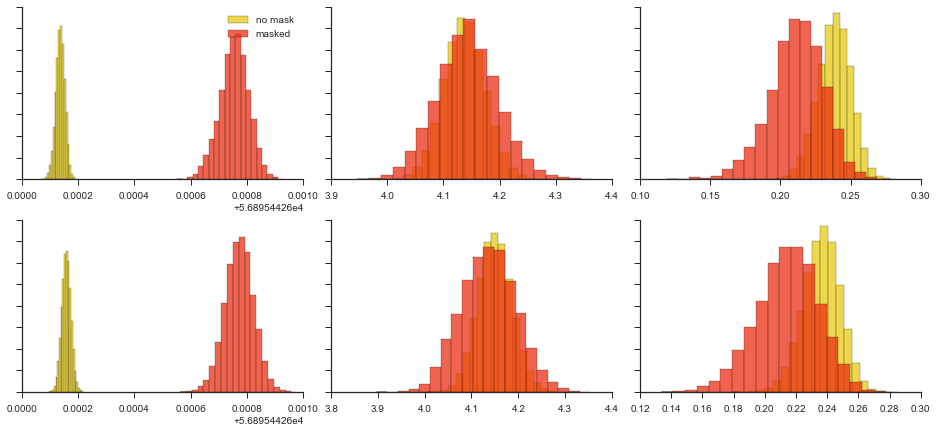

In [15]:
pars = 'tc rho b'.split()

with sb.axes_style('ticks'):
    fig,axs = subplots(2,3,figsize=(13,6))
    for i,p in enumerate(pars):
        rng = get_range(pn.wn_nomask[p],pn.gp_nomask[p])
        pn.wn_nomask[p].hist(ax=axs.flat[i], fc=cp[12], bins = 20, label='no mask', grid=False, alpha=0.75)
        pn.gp_nomask[p].hist(ax=axs.flat[i], fc=cp[14], bins = 20, label='masked', grid=False, alpha=0.75)
        setp(axs.flat[i].get_yticklabels(), visible=False)
    for i,p in enumerate(pars):
        rng = get_range(pn.wn_nomask[p],pn.gp_nomask[p])
        pn.wn_masked[p].hist(ax=axs.flat[i+3], fc=cp[12], bins = 20,label='no mask', grid=False, alpha=0.75)
        pn.gp_masked[p].hist(ax=axs.flat[i+3], fc=cp[14],bins = 20, label='masked', grid=False, alpha=0.75)
        setp(axs.flat[i+3].get_yticklabels(), visible=False)
    axs.flat[0].legend()
    sb.despine(fig)
    fig.tight_layout()

### Residual extinction

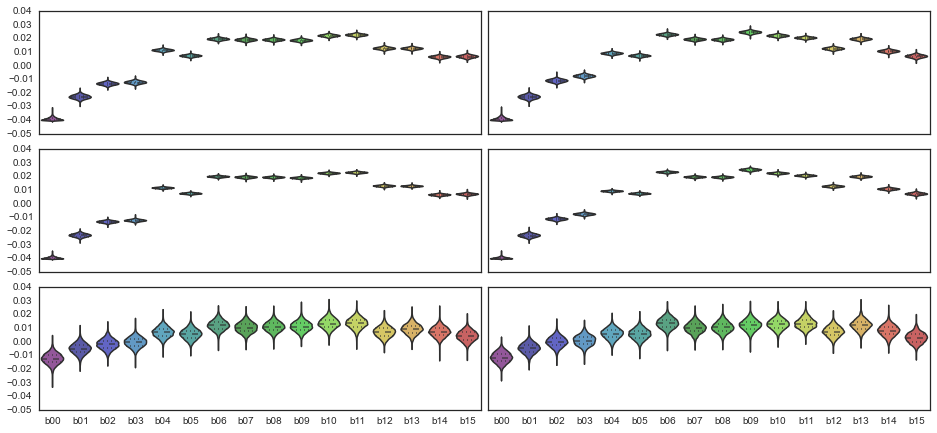

In [20]:
fig,axs = subplots(3,2,figsize=(13,6), sharey=True, sharex=True)
for i,(p1,p2) in enumerate(zip(ch_names[0::2],ch_names[1::2])):
    sb.violinplot(px[p1], ax=axs[i,0], color=cp, alpha=0.75)
    sb.violinplot(px[p2], ax=axs[i,1], color=cp, alpha=0.75)
fig.tight_layout()

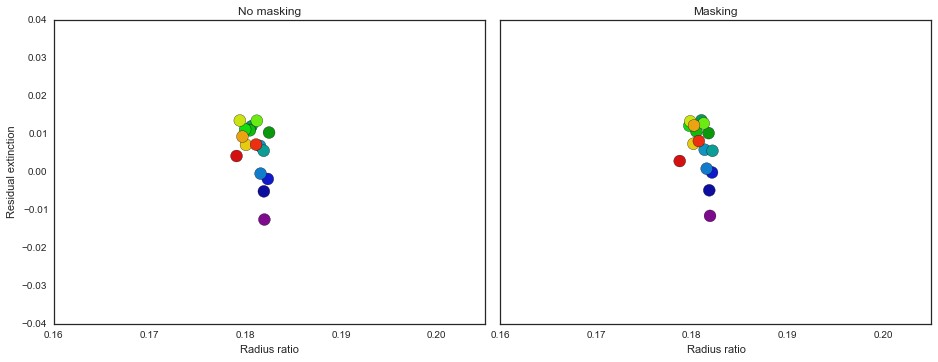

In [21]:
fig,axs = subplots(1,2,sharey=True, sharex=True)
axs[0].scatter(pk.gp_nomask.mean(0), px.gp_nomask.mean(0), marker='o', c=cp, s=140)
axs[1].scatter(pk.gp_masked.mean(0), px.gp_masked.mean(0), marker='o', c=cp, s=140)
setp(axs[0], ylabel='Residual extinction', title='No masking')
setp(axs[1], title='Masking')
setp(axs, xlabel='Radius ratio')
fig.tight_layout()

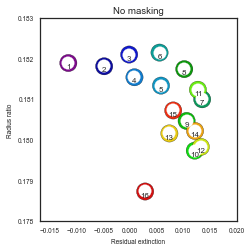

In [22]:
with sb.plotting_context('paper', rc=rc_paper):
    fig,ax = subplots(1,1,figsize=(AAOCW,AAOCW))
    ax.scatter(px.gp_masked.mean(0), pk.gp_masked.mean(0), marker='o', c=cp, s=300)
    ax.scatter(px.gp_masked.mean(0), pk.gp_masked.mean(0), marker='o', c='w', s=160, edgecolor='w')
    [ax.text(x,y-0.00008,i+1, ha='center',va='center',size=8) for i,(x,y) in 
     enumerate(zip(px.gp_masked.mean(0), pk.gp_masked.mean(0)))]
    setp(ax, xlabel='Residual extinction', ylabel='Radius ratio', title='No masking', 
         ylim=(0.178,0.183),xlim=(-0.017,0.02))
    fig.tight_layout()
    fig.savefig('plots/pub_k_vs_x.pdf')

In [23]:
from matplotlib.colors import LinearSegmentedColormap

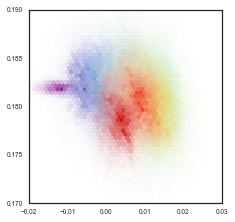

In [24]:
with sb.plotting_context('paper', rc=rc_paper):
    fig,ax = subplots(1,1,figsize=(AAOCW,AAOCW))
    hs = []
    for i in range(16):
        cml = LinearSegmentedColormap.from_list('blah', [[1,1,1,0],cp[i]])
        hs.append(ax.hexbin(array(px.gp_masked)[:,i], array(pk.gp_masked)[:,i], 
          extent=(-0.02,0.03,0.17,0.19), gridsize=50, cmap=cml))
        if i>0:
            hs[-1].set_facecolors(hs[-2].get_facecolors())
        fig.canvas.draw()
    fig.canvas.draw()

In [25]:
corrcoef(px.gp_masked.mean(0), pk.gp_masked.mean(0))

array([[ 1.        , -0.44865167],
       [-0.44865167,  1.        ]])

**Note:** The correlation between the residual extinction and radius ratio is rather clear.

### Average noise

There are no surprises here. The average noise increases towards red and blue ends of the spectrum, and the bin `b09` containing the strong telluric O$_2$ absorption band is an outlier.

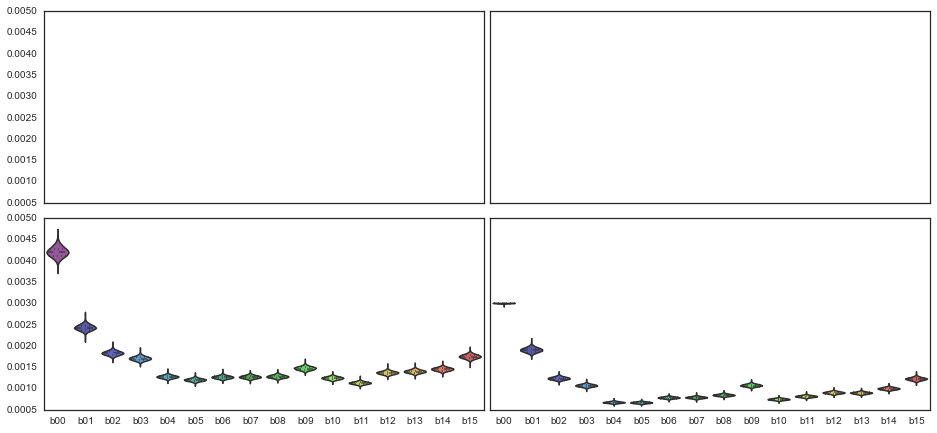

In [29]:
fig,ax = subplots(2,2,figsize=(13,6), sharey=True, sharex=True)
#sb.violinplot(pe.wn_nomask, ax=ax[0,0], color=cp, alpha=0.75)
sb.violinplot(pe.wn_masked, ax=ax[1,0], color=cp, alpha=0.75)
#sb.violinplot(pe.dw_nomask, ax=ax[0,1], color=cp, alpha=0.75)
sb.violinplot(pe.dw_masked, ax=ax[1,1], color=cp, alpha=0.75)
fig.tight_layout()

### Limb darkening 

In [30]:
uper = array(percentile(pl.gp_masked[us], [50,0.5,99.5], 0))
vper = array(percentile(pl.gp_masked[vs], [50,0.5,99.5], 0))
um,ue = uper[0,:], abs(uper[1:,:]-uper[0,:]).mean(0)
vm,ve = vper[0,:], abs(vper[1:,:]-vper[0,:]).mean(0)

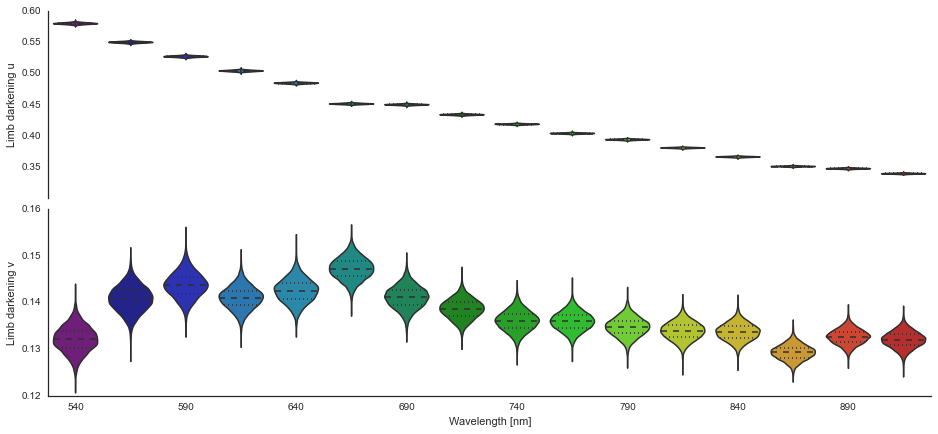

In [31]:
fig,axs = subplots(2,1,figsize=(13,6),sharex=True)
sb.violinplot(array(pl.gp_masked[us])[::10,:], ax=axs[0], names=pnames, color=cp)
sb.violinplot(array(pl.gp_masked[vs])[::10,:], ax=axs[1], names=pnames, color=cp)
sb.despine(fig)
sb.despine(ax=axs[0], bottom=True)
setp(axs[0], yticks=linspace(0.35,0.60,6), ylabel='Limb darkening u')
setp(axs[1], yticks=[0.12,0.13,0.14,0.15,0.16], ylabel='Limb darkening v', xlabel='Wavelength [nm]')
fig.tight_layout()

### Radius ratios 

In [32]:
bids = [int(c[1:]) for c in pk.wn_nomask.columns]
stitles =  'White noise,GP,Divide-by-white'.split(',')
chs_n = [pk.wn_nomask, pk.gp_nomask, pk.dw_nomask]
chs_m = [pk.wn_masked, pk.gp_masked, pk.dw_masked]
chr_n = [pr.wn_nomask, pr.gp_nomask, pr.dw_nomask]
chr_m = [pr.wn_masked, pr.gp_masked, pr.dw_masked]

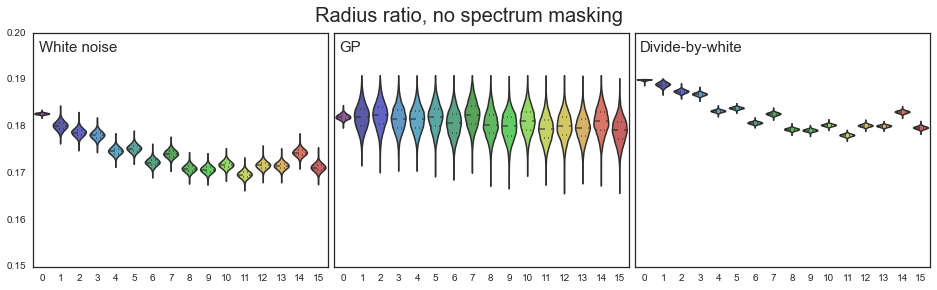

In [33]:
fig,axs = subplots(1,3,figsize=(13,4), sharey=True)
for ax,ch,stitle in zip(axs,chs_n, stitles):
    sb.violinplot(ch, ax=ax, color=cp, alpha=0.75, names=bids)
    ax.text(0.02, 0.92, stitle, transform=ax.transAxes, size=15)
fig.suptitle('Radius ratio, no spectrum masking', size=20)
setp(axs, ylim=(0.15,0.20))
fig.tight_layout()
fig.subplots_adjust(top=0.89)

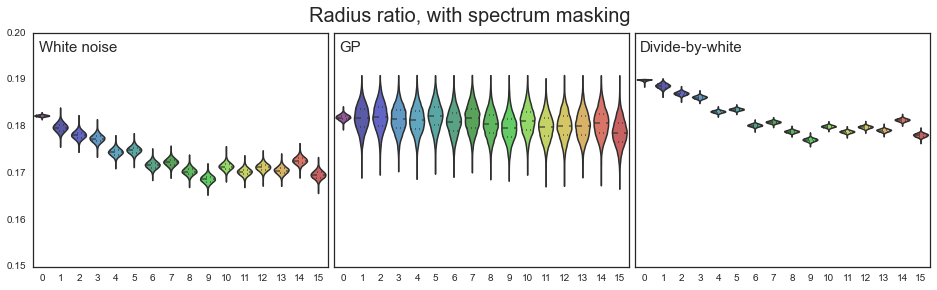

In [34]:
fig,axs = subplots(1,3,figsize=(13,4), sharey=True)
for ax,ch,stitle in zip(axs,chs_m,stitles):
    sb.violinplot(ch, ax=ax, color=cp, alpha=0.75, names=bids)
    ax.text(0.02, 0.92, stitle, transform=ax.transAxes, size=15)
fig.suptitle('Radius ratio, with spectrum masking', size=20)
setp(axs, ylim=(0.15,0.20))
fig.tight_layout()
fig.subplots_adjust(top=0.89)

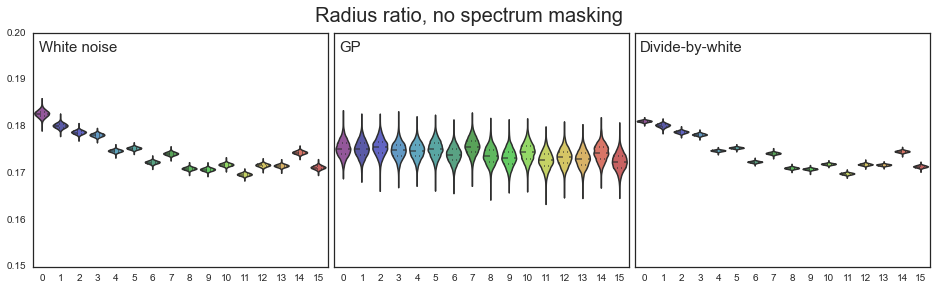

In [35]:
fig,axs = subplots(1,3,figsize=(13,4), sharey=True)
for ax,ch,stitle in zip(axs,chr_n,stitles):
    sb.violinplot(ch, ax=ax, color=cp, alpha=0.75, names=bids)
    ax.text(0.02, 0.92, stitle, transform=ax.transAxes, size=15)
fig.suptitle('Radius ratio, no spectrum masking', size=20)
setp(axs, ylim=(0.15,0.20))
fig.tight_layout()
fig.subplots_adjust(top=0.89)

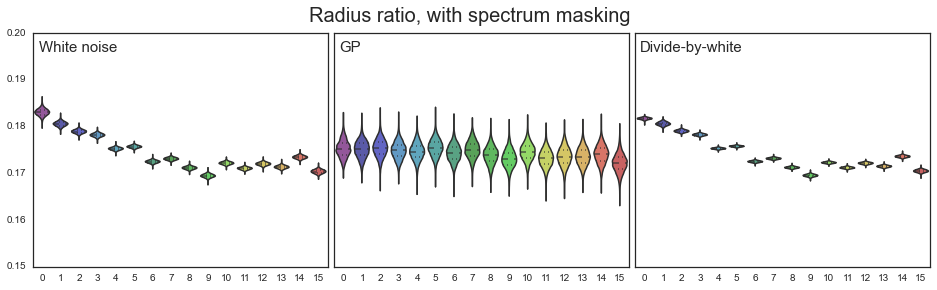

In [36]:
fig,axs = subplots(1,3,figsize=(13,4), sharey=True)
for ax,ch,stitle in zip(axs,chr_m,stitles):
    sb.violinplot(ch, ax=ax, color=cp, alpha=0.75, names=bids)
    ax.text(0.02, 0.92, stitle, transform=ax.transAxes, size=15)
fig.suptitle('Radius ratio, with spectrum masking', size=20)
setp(axs, ylim=(0.15,0.20))
fig.tight_layout()
fig.subplots_adjust(top=0.89)

In [37]:
def peb(ax, pn, shift=0, plot_line=False):
    pp = percentile(pn, [50, 16, 84], 0)
    pm,pe = pp[0], abs(pp[1:]-pp[0]).mean()
    ax.errorbar(pb_centers+shift, pm, yerr=pe, fmt='k.', lw=1)
    if plot_line:
        ax.plot(pb_centers, pm, 'k', drawstyle='steps-mid', alpha=0.25, lw=1)

In [38]:
k0 = 0.158
dh = H(TEQ, 10**LOGGP*1e-2)/RSTAR

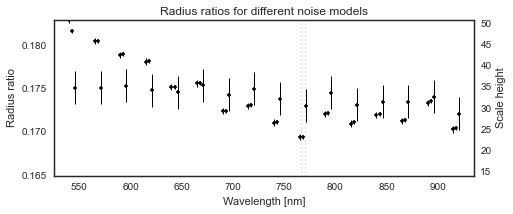

In [39]:
fig,axk = subplots(1,1, figsize=(AAPGW,0.85*AAOCW), sharey=True)
axh = axk.twinx()
ya,yb = 0.165,0.183
peb(axk, pr.wn_masked)
peb(axk, pr.dw_masked, 3)
peb(axk, pr.gp_masked, 6)
axk.axhline(k0, c='k', ls=':', lw=1)
[axk.axvline(l, lw=1, ls=':', alpha=0.25, c='k') for l in [766.5,769.9]]
setp(axk, xlabel='Wavelength [nm]', ylim=(ya,yb), xlim=(525,935),
     ylabel='Radius ratio', title='Radius ratios for different noise models')
setp(axh, ylabel='Scale height', ylim=((ya-k0)/dh, (yb-k0)/dh))
fig.tight_layout()

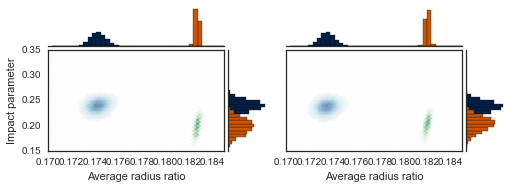

In [40]:
def hexbin2(fig, ax, a1, a2, b1, b2, alim, blim, gs):
    h1 = ax.hexbin(a1, b1, extent=(alim[0],alim[1],blim[0],blim[1]), 
                   gridsize=gs, cmap=plt.cm.Blues)
    h2 = ax.hexbin(a2, b2, extent=(alim[0],alim[1],blim[0],blim[1]), 
                   gridsize=gs, cmap=plt.cm.Greens)
    fig.canvas.draw()
    fc = h1.get_facecolors() + h2.get_facecolors()
    fc *= 0.5
    fc[fc[:,:3].sum(1)>2.9,:] = array([1,1,1,1])
    h2.set_facecolors(fc)
    fig.canvas.draw()
    ax.set_xlim(*klim)
    ax.set_ylim(*blim)
    
klim = (0.17,0.185) 
blim = (0.15,0.35)
msize, mpad = 0.55, 0.05

fig, axs = subplots(1,2, figsize=(AAPGW,0.75*AAOCW), sharey=True, sharex=True)
divs = [make_axes_locatable(ax) for ax in axs]
axhys = [div.append_axes('top',   size=msize, pad=mpad, sharex=axs[i]) for i,div in enumerate(divs)]
axhxs = [div.append_axes('right', size=msize, pad=mpad, sharey=axs[i]) for i,div in enumerate(divs)]

hexbin2(fig, axs[0], pk.wn_nomask.mean(1), pk.dw_nomask.mean(1), pn.wn_nomask.b, pn.dw_nomask.b, klim, blim, 50)
hexbin2(fig, axs[1], pk.wn_masked.mean(1), pk.dw_masked.mean(1), pn.wn_masked.b, pn.dw_masked.b, klim, blim, 50)

axhys[0].hist(pk.wn_nomask.mean(1),  bins=40, range=klim, alpha=1, normed=True)
axhys[0].hist(pk.dw_nomask.mean(1),  bins=40, range=klim, alpha=1, normed=True)
axhxs[0].hist(pn.wn_nomask.b,  bins=30, range=blim, alpha=1, orientation='horizontal', normed=True)
axhxs[0].hist(pn.dw_nomask.b,  bins=30, range=blim, alpha=1, orientation='horizontal', normed=True)
axhys[1].hist(pk.wn_masked.mean(1),  bins=40, range=klim, alpha=1, normed=True)
axhys[1].hist(pk.dw_masked.mean(1),  bins=40, range=klim, alpha=1, normed=True)
axhxs[1].hist(pn.wn_masked.b,  bins=30, range=blim, alpha=1, orientation='horizontal', normed=True)
axhxs[1].hist(pn.dw_masked.b,  bins=30, range=blim, alpha=1, orientation='horizontal', normed=True)

setp(axhys[0].get_yticklabels()+axhys[1].get_yticklabels(), visible=False)
setp(axhys[0].get_xticklabels()+axhys[1].get_xticklabels(), visible=False)
setp(axhxs[0].get_yticklabels()+axhxs[1].get_yticklabels(), visible=False)
setp(axhxs[0].get_xticklabels()+axhxs[1].get_xticklabels(), visible=False)

[sb.despine(ax=a, left=True) for a in axhys]
[sb.despine(ax=a, bottom=True) for a in axhxs]

setp(axs[0], xlim=klim, ylim=blim)
setp(axhxs, ylim=blim)
setp(axs[0], xlabel='Average radius ratio', ylabel='Impact parameter')
setp(axs[1], xlabel='Average radius ratio')
fig.tight_layout()

## Plots for the paper

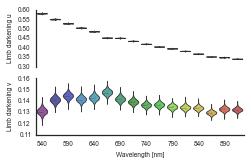

In [51]:
with sb.plotting_context('paper', rc=rc_paper):
    cpars = dict(names=pnames, color=cp, lw=0.75, alpha=0.75, inner_kws={'lw':0.5})
    fig,axs = subplots(2,1,figsize=(AAOCW,0.65*AAOCW),sharex=True)
    sb.violinplot(array(pl.gp_masked[us])[::5,:], ax=axs[0], **cpars)
    sb.violinplot(array(pl.gp_masked[vs])[::5,:], ax=axs[1], **cpars)
    sb.despine(fig)
    sb.despine(ax=axs[0], bottom=True)
    setp(axs[0], yticks=linspace(0.30,0.60,7), ylabel='Limb darkening u')
    setp(axs[1], yticks=[0.11,0.12,0.13,0.14,0.15,0.16], ylabel='Limb darkening v', xlabel='Wavelength [nm]')
    fig.tight_layout()
    fig.savefig('plots/pub_ldc.pdf')

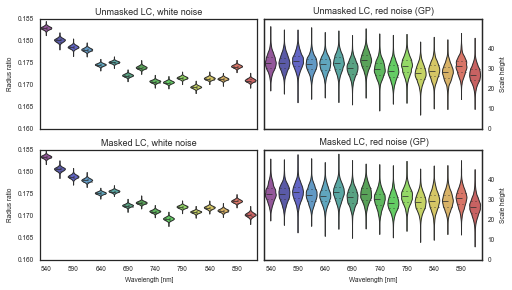

In [ ]:
k0 = 0.158
dh = H(TEQ, 10**LOGGP*1e-2)/RSTAR

with sb.plotting_context('paper', rc=rc_paper):
    ya,yb = 0.16,0.185
    fig,axk = subplots(2,2, figsize=(AAPGW,1.15*AAOCW), sharey=True, sharex=True)
    axh = axk[0,1].twinx(), axk[1,1].twinx()
    sb.violinplot(pr.wn_nomask, ax=axk[0,0], names=pnames, color=cp, lw=1, alpha=0.75, inner_kws={'lw':1})
    sb.violinplot(pr.gp_nomask, ax=axk[0,1], names=pnames, color=cp, lw=1, alpha=0.75, inner_kws={'lw':1})
    sb.violinplot(pr.wn_masked, ax=axk[1,0], names=pnames, color=cp, lw=1, alpha=0.75, inner_kws={'lw':1})
    sb.violinplot(pr.gp_masked, ax=axk[1,1], names=pnames, color=cp, lw=1, alpha=0.75, inner_kws={'lw':1})
    [a.axhline(k0, c='k', ls=':', lw=1, alpha=0.5) for a in axk.flat]
    setp(axk, ylim=(ya,yb))
    setp(axk[1,:], xlabel='Wavelength [nm]')
    setp(axk[:,0], ylabel='Radius ratio')
    [a.set_title(t, dict(fontsize=9)) 
     for a,t in zip(axk.flat, 'Unmasked LC, white noise;Unmasked LC, red noise (GP);' 
                              'Masked LC, white noise; Masked LC, red noise (GP)'.split(';'))]
    setp(axh, ylabel='Scale height', ylim=((ya-k0)/dh, (yb-k0)/dh), yticks=linspace(0,40,5))
    fig.tight_layout()
    fig.savefig('plots/pub_ts_v.pdf')

---
<center> &copy; 2015 <a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a></center>